In [ ]:
from torch import nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt



In [2]:
def number_to_feature_vector(n, n_min=0, n_max=1000):
    """
    Convert a number to a 42-feature vector:
    - 10 least significant digits from binary, ternary, quinary, septenary representations
    - Normalized number
    - Normalized logarithm of the number
    
    Parameters:
    n (int/float): Input number (positive)
    n_min (float): Minimum value for normalization (default: 0)
    n_max (float): Maximum value for normalization (default: 1000)
    
    Returns:
    np.array: 42-dimensional feature vector
    """
    # Initialize the feature vector
    feature_vector = []
    
    # Helper function to convert number to base and get k least significant digits
    def to_base_digits(num, base, k=10):
        if num == 0:
            return [0] * k
        digits = []
        while num > 0 and len(digits) < k:
            digits.append(num % base)
            num //= base
        # Pad with zeros if needed
        while len(digits) < k:
            digits.append(0)
        # Return k least significant digits (reverse since we built it backwards)
        return digits[::-1][:k]
    
    # Get 10 least significant digits for each base
    bases = [2, 3, 5, 7]  # Binary, ternary, quinary, septenary
    for base in bases:
        digits = to_base_digits(int(n), base, 10)
        feature_vector.extend(digits)
    
    # Normalize the number (min-max scaling)
    n_norm = (n - n_min) / (n_max - n_min) if n_max != n_min else 0.0
    feature_vector.append(n_norm)
    
    # Compute and normalize logarithm (use natural log, handle log(0) case)
    log_n = np.log(n) if n > 0 else 0.0
    # Normalize log (assuming log range based on n_min, n_max)
    log_min = np.log(n_min) if n_min > 0 else -10  # Arbitrary small value
    log_max = np.log(n_max) if n_max > 0 else 10   # Arbitrary large value
    log_norm = (log_n - log_min) / (log_max - log_min) if log_max != log_min else 0.0
    feature_vector.append(log_norm)
    
    # Convert to numpy array
    return np.array(feature_vector)



In [17]:
class Neural_nets(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
                nn.Linear(42, 100),         # Input: 42 features, Output: 100 features        # Batch normalization for 100 features
                nn.ReLU(),
                nn.Linear(100, 100),        # Input: 100 features, Output: 200 features
                nn.BatchNorm1d(100),        # Batch normalization for 200 features
                nn.ReLU(),
                nn.Linear(100, 100),        # Input: 100 features, Output: 200 features
                nn.BatchNorm1d(100),        # Batch normalization for 200 features
                nn.ReLU(),
                nn.Linear(100, 10),        # Input: 100 features, Output: 200 features
                nn.ReLU(),
                nn.Linear(10, 1),          # Output: 1 value (regression)
    
            )
        
    def forward(self,x):
        logits = self.linear(x)
        return logits

In [18]:
class golbach_datasets(Dataset):
    def __init__(self,file_name):
        self.df = pd.read_csv(file_name)
        self.number = self.df["Even_number"]
        self.combination = self.df["combination"]
        self.numbers = []
        for i in self.number:
            self.numbers.append(number_to_feature_vector(i))
        self.numbers = np.array(self.numbers)        

    def __len__(self):
        return len(self.number)
    
    def __getitem__(self, index):
        return {"number":self.numbers[index],"combination":self.combination[index]}
        

In [19]:
data = golbach_datasets("data.csv")

In [20]:
function = Neural_nets()

In [21]:
data_loader = DataLoader(data, batch_size=2,shuffle=True,drop_last=True)


In [22]:
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.SGD(function.parameters(), lr=0.01)


In [ ]:
def train_epoch():
    running_loss = 0.


    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(data_loader):
        # Every data instance is an input + label pair
        inputs, labels = data["number"].to(dtype =torch.float32) , data["combination"].to(dtype = torch.float32)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        inputs = inputs.squeeze()
        outputs = function(inputs)
        if (i == 1):
            print(outputs)
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(function.parameters(), max_norm=1.0)
        # Adjust learning weights
        optimizer.step()
        # Gather data and report
        running_loss += loss.item()


    return running_loss/len(data_loader)

In [24]:
epochs = 10

for epoch in range(epochs):

    function.train(True)
    avg_loss = train_epoch()
    print(f"Epoch:{epoch+1} loss:{avg_loss}")

/home/saurav/.local/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([[0.4084],
        [0.2877]], grad_fn=<AddmmBackward0>)
Epoch:1 loss:2638274.9473523055
tensor([[2241.9365],
        [2242.3394]], grad_fn=<AddmmBackward0>)
Epoch:2 loss:2610191.013661669
tensor([[2332.2585],
        [2333.7581]], grad_fn=<AddmmBackward0>)
Epoch:3 loss:2610209.595817591
tensor([[2266.1702],
        [2266.2949]], grad_fn=<AddmmBackward0>)
Epoch:4 loss:2610937.7955685263
tensor([[2325.6758],
        [2325.7214]], grad_fn=<AddmmBackward0>)
Epoch:5 loss:2610393.4781173775
tensor([[2293.9136],
        [2294.1694]], grad_fn=<AddmmBackward0>)
Epoch:6 loss:2611818.7673148178
tensor([[2236.7964],
        [2236.6294]], grad_fn=<AddmmBackward0>)
Epoch:7 loss:2610931.295352113
tensor([[2172.8484],
        [2172.7976]], grad_fn=<AddmmBackward0>)
Epoch:8 loss:2609743.5399461845
tensor([[2237.8191],
        [2284.1658]], grad_fn=<AddmmBackward0>)
Epoch:9 loss:2609615.552472457
tensor([[2191.3135],
        [2191.2043]], grad_fn=<AddmmBackward0>)
Epoch:10 loss:2609723.6771612535

In [29]:
function.eval()
vec = number_to_feature_vector(100)
vec = torch.tensor(vec, dtype=torch.float32)
vec = vec.unsqueeze(0)
with torch.no_grad():
    out = function(vec) 
    print(out)

tensor([[3012.0010]])


In [31]:
df = pd.read_csv("data.csv")
df.head()
print(len(df))

336645


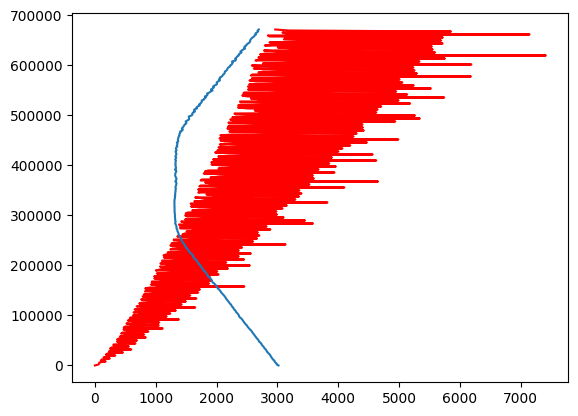

In [51]:
even_number = df["Even_number"][::1000]

combination = df["combination"][::1000]
tensors =[]
function.eval()
out_lis = []

for i in even_number:
    tensors.append(torch.tensor(number_to_feature_vector(i),dtype=torch.float32))
with torch.no_grad():
    for j in tensors:
        
        out  = function(j.unsqueeze(0))
        out_lis.append(out.item())
plt.plot(combination, even_number, color="red")
plt.plot(out_lis,even_number)